## Module install and import

In [3]:
# Standard / Scientific
import math
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# SciPy
from scipy.stats import (
    anderson,
    chi2_contingency,
    mannwhitneyu,
    pointbiserialr,
    shapiro,
    spearmanr
)

# Statsmodels
import statsmodels.api as sm
from statsmodels.graphics.mosaicplot import mosaic
from statsmodels.stats.outliers_influence import variance_inflation_factor

# scikit-learn
import sklearn as sk
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)
from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split
)
from sklearn.preprocessing import StandardScaler

# imbalanced-learn
from imblearn.over_sampling import SMOTE

# LightGBM
from lightgbm import LGBMClassifier

# XGBoost
from xgboost import XGBClassifier

# SHAP
import shap

---
## Dataset import and def

In [4]:
df = pd.read_csv('stk.csv')
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,38920,0,0.48,0,0,0,0,0,73.02,28.1,0,0
1,11658,0,1.08,0,0,0,0,1,74.50,28.1,0,0
2,69768,1,1.32,0,0,0,0,0,70.37,28.1,0,1
3,32147,0,1.32,0,0,0,0,1,107.02,28.1,0,0
4,32514,0,1.80,0,0,0,0,0,68.80,28.1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,45893,1,8.00,0,0,0,0,0,106.51,12.3,0,0
5106,20364,1,4.00,0,0,0,0,0,107.25,12.0,0,0
5107,59993,0,40.00,0,0,1,1,1,60.96,11.5,1,0
5108,3205,1,79.00,0,0,1,2,0,79.03,11.3,0,0


In [ ]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

---
## 변수 확인

In [5]:
# 범주형 
binary_cols = [
    'hypertension','heart_disease',
    'ever_married','Residence_type','stroke'
]

# 다범주 - gender의 경우 값 분포가 세 가지이므로 일단 여기에 배치 
multi_cols = [
    'gender', 'smoking_status','work_type'
]

# 시각화를 위한 컬럼 정의 
label_maps = {
    'gender': {0: 'Male', 1: 'Female', 3:'UnKnown'},
    'hypertension': {0: 'No', 1: 'Yes'},
    'heart_disease': {0: 'No', 1: 'Yes'},
    'ever_married': {0: 'No', 1: 'Yes'},
    'Residence_type': {0: 'Urban', 1: 'Rural'},
    'stroke': {0: 'No', 1: 'Yes'},
    'smoking_status': {
        0: 'Unknown',
        1: 'Never smoked',
        2: 'Smokes',
        3: 'Formerly smoked'},
    'work_type': {
        0: 'Private',
        1: 'Self-employed',
        2: 'Govt_job',
        3: 'Children',
        4: 'Never_work'}
}

# 변수별 시각화
def plot_discrete_grid(df, cols, palette, n_cols=3, figsize_unit=(5,4)):

    n_rows = math.ceil(len(cols) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 6*n_rows))
    axes = axes.flatten()

    for ax, col in zip(axes, cols):
        n_cat = df[col].nunique()

        order_vals = sorted(df[col].unique())

        sns.countplot(
            x=col, hue=col, data=df,
            order=order_vals, 
            palette=palette[:len(order_vals)],
            legend=False, ax=ax
        )

        # 막대 위 count 표시
        for p in ax.patches:
            h = int(p.get_height())
            ax.annotate(
                f'{h}',
                (p.get_x() + p.get_width()/2., h),
                ha='center', va='bottom',
                fontsize=9, xytext=(0,3), textcoords='offset points'
            )

        # x축 라벨 처리 (이진 / 다범주)
        if col in label_maps:
            uniq_vals = sorted(df[col].unique())

            if len(uniq_vals) == 2:   # 이진 변수
                ax.set_xticks([0, 1])
                ax.set_xticklabels([
                    label_maps[col].get(0, '0'),
                    label_maps[col].get(1, '1')
                ])

            else:
                # 다범주 변수 
                tmp_df = df.copy()
                tmp_df['_label'] = tmp_df[col].map(lambda v: label_maps[col].get(v, str(v)))

                order_labels = [label_maps[col].get(v, str(v)) for v in order_vals]

                ax.clear()

                sns.countplot(
                    x='_label',
                    hue='_label',
                    data=tmp_df,
                    order=order_labels,
                    palette=palette[:len(order_labels)],
                    legend=False,
                    ax=ax
                )

                # bar 위 count 표시
                for p in ax.patches:
                    h = int(p.get_height())
                    ax.annotate(
                        f'{h}',
                        (p.get_x() + p.get_width() / 1., h),
                        ha='center', va='bottom',
                        fontsize=9,
                        xytext=(0, 3),
                        textcoords='offset points'
                    )

                # tick 회전
                for tick in ax.get_xticklabels():
                    tick.set_rotation(20)
                    tick.set_ha('right')
   
        ax.set_title(col)
        ax.set_xlabel('')
        ax.set_ylabel('Count')

    for i in range(len(cols), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()

# 색상 정의 
pastel_palette = [
    "#A3C4F3", "#FFD6A5",
    "#FFADAD", "#E4C1F9", "#D0F4DE",
]

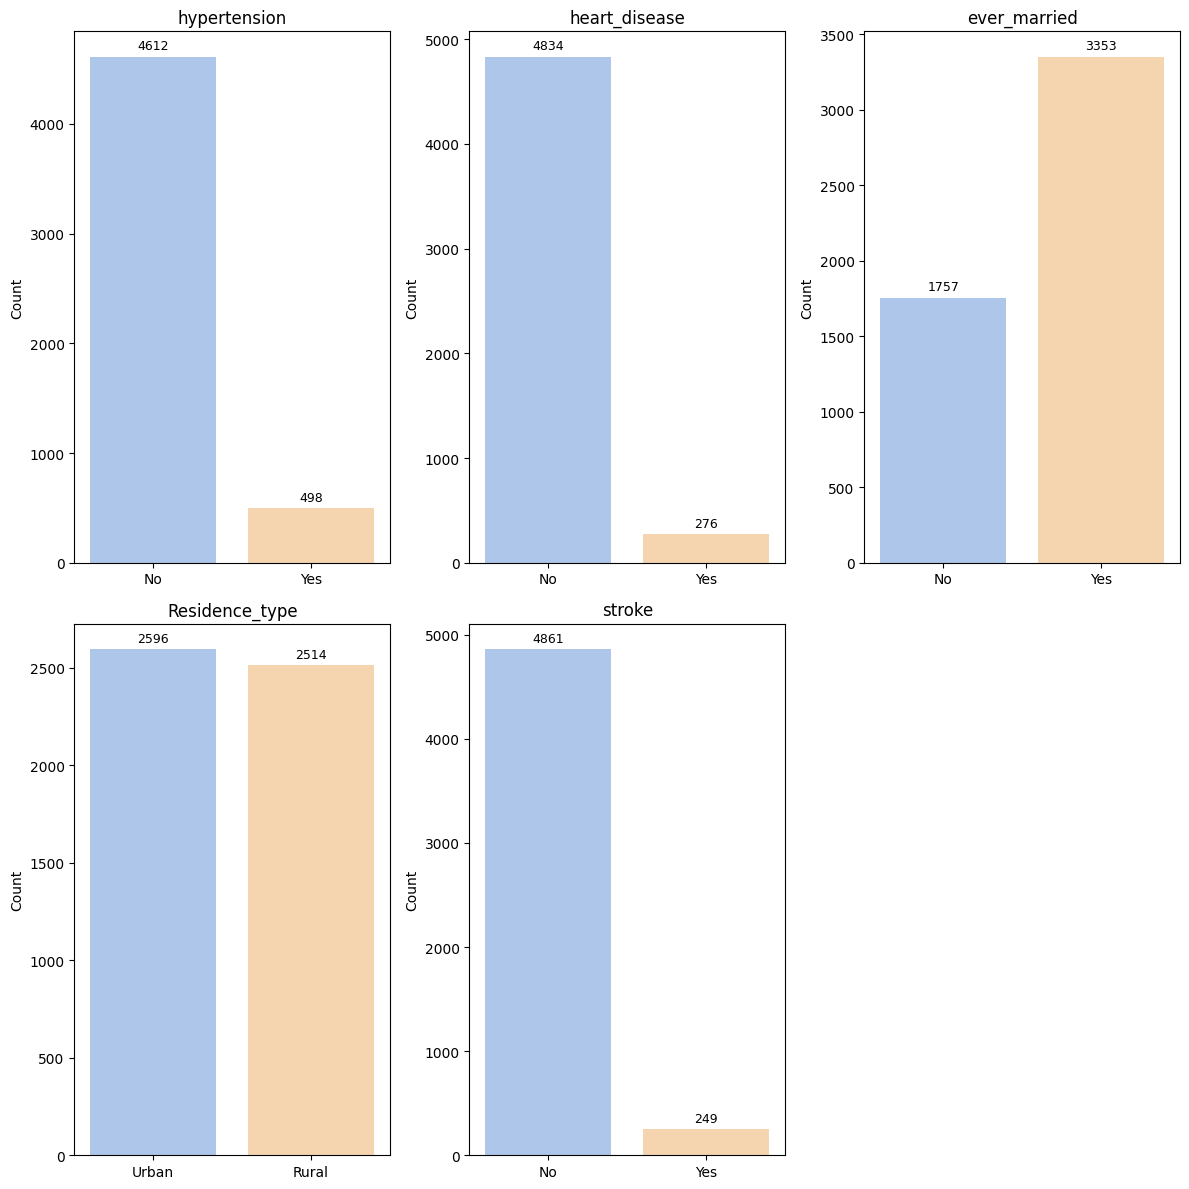

In [6]:
plot_discrete_grid(df, binary_cols, pastel_palette, n_cols=3) # 이진변수 

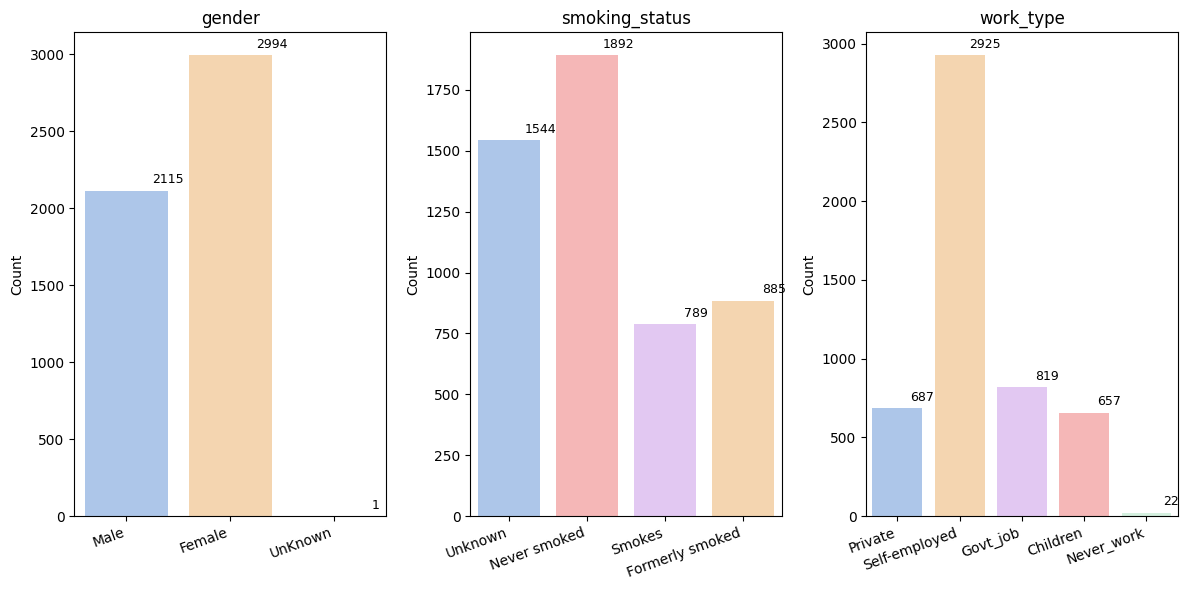

In [7]:
plot_discrete_grid(df, multi_cols, pastel_palette, n_cols=3) # 다범주 

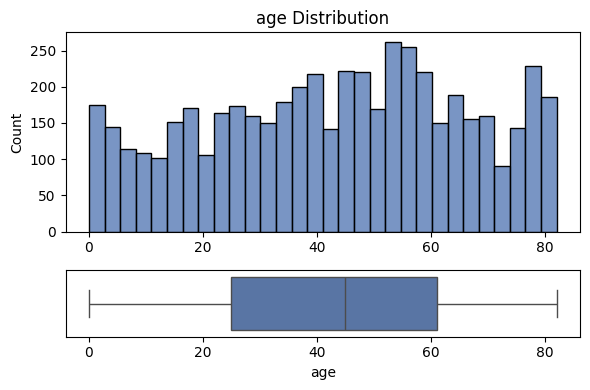

In [8]:
# 연속형 변수 분포 확인 
if "age" in df.columns:
    fig, axes = plt.subplots(
        nrows=2,
        figsize=(6, 4),
        gridspec_kw={"height_ratios": [3, 1]}
    )

    # 1) Histogram (상단)
    sns.histplot(
        data=df,
        x="age",
        bins=30,
        color="#4C72B0",
        edgecolor="black",
        ax=axes[0]
    )
    axes[0].set_title("age Distribution")
    axes[0].set_xlabel("")
    axes[0].set_ylabel("Count")

    # 2) Boxplot (하단)
    sns.boxplot(
        x=df["age"],
        color="#4C72B0",
        flierprops=dict(
            marker='o',
            markersize=4,
            markerfacecolor='black',
            markeredgecolor='black'
        ),
        ax=axes[1]
    )
    axes[1].set_xlabel("age")
    axes[1].set_yticks([])

    plt.tight_layout()
    plt.show()

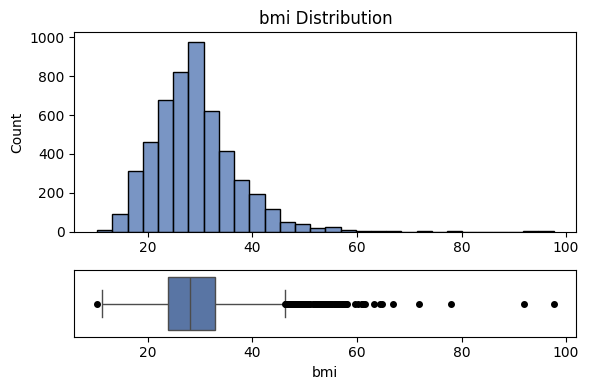

In [9]:
if "bmi" in df.columns:
    fig, axes = plt.subplots(
        nrows=2,
        figsize=(6, 4),
        gridspec_kw={"height_ratios": [3, 1]}
    )

    # 1) Histogram (상단)
    sns.histplot(
        data=df,
        x="bmi",
        bins=30,
        color="#4C72B0",
        edgecolor="black",
        ax=axes[0]
    )
    axes[0].set_title("bmi Distribution")
    axes[0].set_xlabel("")
    axes[0].set_ylabel("Count")

    # 2) Boxplot (하단)
    sns.boxplot(
        x=df["bmi"],
        color="#4C72B0",
        flierprops=dict(
            marker='o',
            markersize=4,
            markerfacecolor='black',
            markeredgecolor='black'
        ),
        ax=axes[1]
    )
    axes[1].set_xlabel("bmi")
    axes[1].set_yticks([])

    plt.tight_layout()
    plt.show()

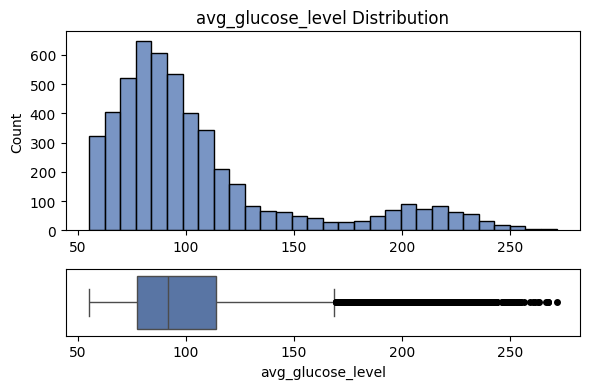

In [10]:
if "avg_glucose_level" in df.columns:
    fig, axes = plt.subplots(
        nrows=2,
        figsize=(6, 4),
        gridspec_kw={"height_ratios": [3, 1]}
    )

    # 1) Histogram (상단)
    sns.histplot(
        data=df,
        x="avg_glucose_level",
        bins=30,
        color="#4C72B0",
        edgecolor="black",
        ax=axes[0]
    )
    axes[0].set_title("avg_glucose_level Distribution")
    axes[0].set_xlabel("")
    axes[0].set_ylabel("Count")

    # 2) Boxplot (하단)
    sns.boxplot(
        x=df["avg_glucose_level"],
        color="#4C72B0",
        flierprops=dict(
            marker='o',
            markersize=4,
            markerfacecolor='black',
            markeredgecolor='black'
        ),
        ax=axes[1]
    )
    axes[1].set_xlabel("avg_glucose_level")
    axes[1].set_yticks([])

    plt.tight_layout()
    plt.show()

In [11]:
# 이상치 수치화
cont_vars = ['age', 'avg_glucose_level', 'bmi']

outlier_results = {}

for col in cont_vars:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower) | (df[col] > upper)]

    outlier_results[col] = {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'lower_bound': lower,
        'upper_bound': upper,
        'n_outliers': len(outliers),
        'outlier_df': outliers[[col]]   # 해당 변수만 출력
    }

# 요약 출력
for col, res in outlier_results.items():
    print(f"=== {col} ===")
    print(f"Q1: {res['Q1']}")
    print(f"Q3: {res['Q3']}")
    print(f"IQR: {res['IQR']}")
    print(f"Lower bound: {res['lower_bound']}")
    print(f"Upper bound: {res['upper_bound']}")
    print(f"Outlier count: {res['n_outliers']}")
    print()


=== age ===
Q1: 25.0
Q3: 61.0
IQR: 36.0
Lower bound: -29.0
Upper bound: 115.0
Outlier count: 0

=== avg_glucose_level ===
Q1: 77.245
Q3: 114.09
IQR: 36.845
Lower bound: 21.977500000000006
Upper bound: 169.35750000000002
Outlier count: 627

=== bmi ===
Q1: 23.8
Q3: 32.8
IQR: 8.999999999999996
Lower bound: 10.300000000000006
Upper bound: 46.29999999999999
Outlier count: 126



---
## 연속형 변수의 정규성 검증 

Anderson-darling 검증 사용으로 변경했습니다. (결과는 동일)  
왜?  
KS, Shapiro보다 이상치·왜도·heavy tail 탐지 능력이 뛰어남 ->
환경·생물·의학 데이터처럼 정규성 위반이 잦은 실데이터에 적합

In [12]:
# 정규성 검증
bmis = anderson(df['bmi'], dist='norm')
avgg = anderson(df['avg_glucose_level'], dist = 'norm')


In [13]:
bmis

AndersonResult(statistic=np.float64(39.36976143191714), critical_values=array([0.576, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(28.862035225048924), scale=np.float64(7.699562318787507))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

- Anderson–Darling
표본 데이터가 특정 분포(보통 정규분포) 를 따르는지  
statistic (통계량) 
critical_values = [15% 대응값(0.576), 10%값, 5%...] <-> significance_level = [15, 10, 5, 2.5, 1] %

    해석: statistic > critical_value  
    Yes → 정규 아님  
    No → 정규성 기각 못 함  

    5% 기준에서 39.37>0.786 -> 정규 아님

In [14]:
avgg

AndersonResult(statistic=np.float64(352.0862926093696), critical_values=array([0.576, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(106.14767710371818), scale=np.float64(45.28356015058198))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

즉, 352 >>> 0.785; 정규 아님

---
### spearman corr
연속형 변수 간 관계 탐색

In [15]:
vars_num = ['avg_glucose_level', 'bmi']

corr, pval = spearmanr(df[vars_num])

corr_df = pd.DataFrame(corr, index=vars_num, columns=vars_num)
pval_df = pd.DataFrame(pval, index=vars_num, columns=vars_num)
corr_df, pval_df

(                   avg_glucose_level       bmi
 avg_glucose_level           0.111914  0.111914
 bmi                         0.111914  0.111914,
                    avg_glucose_level           bmi
 avg_glucose_level       1.029177e-15  1.029177e-15
 bmi                     1.029177e-15  1.029177e-15)

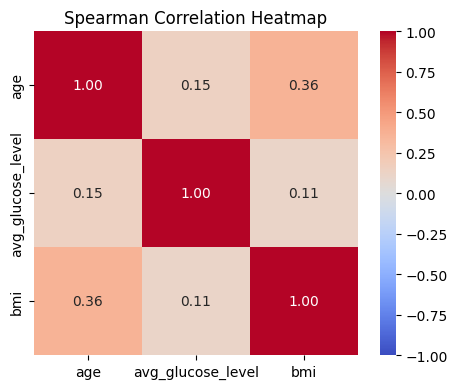

In [16]:
vars_num = ['age', 'avg_glucose_level', 'bmi']

corr = df[vars_num].corr(method='spearman')

plt.figure(figsize=(5,4))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    vmin=-1, vmax=1,
    square=True
)
plt.title('Spearman Correlation Heatmap')
plt.tight_layout()
plt.show()

In [17]:
# stroke와 Spearman 상관
for v in vars_num:
    rho, p = spearmanr(df[v], df['stroke'])
    print(f"{v}: rho={rho:.3f}, p={p:.3e}")

age: rho=0.250, p=2.193e-73
avg_glucose_level: rho=0.083, p=3.442e-09
bmi: rho=0.051, p=2.749e-04


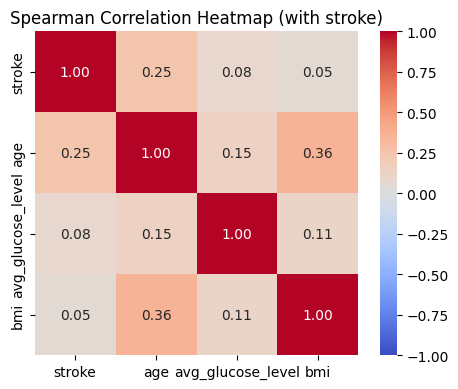

In [18]:
vars_with_y = ['stroke', 'age', 'avg_glucose_level', 'bmi']

corr_y = df[vars_with_y].corr(method='spearman')

plt.figure(figsize=(5,4))
sns.heatmap(
    corr_y,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    vmin=-1, vmax=1,
    square=True
)
plt.title('Spearman Correlation Heatmap (with stroke)')
plt.tight_layout()
plt.show()

---
### 연속형 <-> 범주형 상관성 확인

In [19]:
binary = ['gender','hypertension','heart_disease','ever_married','Residence_type']

res = []
for b in binary:
    r, p = pointbiserialr(df[b], df['age'])
    res.append({
        'variable': b,
        'r': r,
        'p_value': p
    })

res_df = pd.DataFrame(res).sort_values('r', key=abs, ascending=False)
res_df


,variable,r,p_value
3,ever_married,0.679125,0.000000e+00
1,hypertension,0.276398,2.860262e-90
2,heart_disease,0.263796,4.185819e-82
0,gender,0.026956,5.400228e-02
4,Residence_type,-0.014180,3.108450e-01


- age <-> ever_married: 연령의 대리변수 가능

---
## Mann–Whitney U 검정

In [20]:
vars_num = ['age', 'avg_glucose_level', 'bmi']

for v in vars_num:
    g0 = df.loc[df['stroke'] == 0, v].dropna()
    g1 = df.loc[df['stroke'] == 1, v].dropna()

    u, p = mannwhitneyu(g0, g1, alternative='two-sided') # 정규성 가정 없이 분포(중앙값 차이) 비교

    print(f"{v}: U={u:.1f}, p={p:.3e}")

age: U=200263.5, p=3.727e-71
avg_glucose_level: U=471239.0, p=3.640e-09
bmi: U=522642.5, p=2.769e-04


age
U=200,263.5, p=3.7×10⁻⁷¹  
매우 강한 차이  
stroke=1 그룹의 연령이 더 높을 가능성이 큼  

avg_glucose_level  
U=471,239.0, p=3.6×10⁻⁹  
강한 유의성  
혈당 수준 분포가 stroke 여부에 따라 차이 존재  

bmi  
U=522,642.5, p=2.8×10⁻⁴  
유의하나 상대적으로 약함  

stroke 발생군(stroke=1)은 age, avg_glucose_level, bmi 모두에서 중앙값이 더 높을 가능성 확인   
-> Mann–Whitney 검정은 차이가 있는지만 말해줌, 다음 코드 수행은 차이의 방향과 크기를 해석 가능

In [21]:
for v in vars_num:
    med0 = np.median(df.loc[df['stroke'] == 0, v].dropna())
    med1 = np.median(df.loc[df['stroke'] == 1, v].dropna())

    print(f"{v}: median stroke=0 → {med0:.2f}, stroke=1 → {med1:.2f}")

age: median stroke=0 → 43.00, stroke=1 → 71.00
avg_glucose_level: median stroke=0 → 91.47, stroke=1 → 105.22
bmi: median stroke=0 → 28.10, stroke=1 → 28.10


| 변수                | stroke=0 중앙값 | stroke=1 중앙값 | 중앙값 차이 | 통계적 해석          |
| ----------------- | -----------: | -----------: | -----: | --------------- |
| age               |        43.00 |        71.00 | +28.00 | 매우 큼 · 핵심 위험요인  |
| avg_glucose_level |        91.47 |       105.22 | +13.75 | 명확한 증가 · 실질적 연관 |
| bmi               |        28.10 |        28.10 |   0.00 | 중앙값 기준 차이 없음    |


---
## 범주형 변수의 독립성 검정

두 범주형 변수가 서로 관련이 있는지 확인  

X와 Y가 서로 독립인가, 아니면 연관이 있는가?  
 -> 독립이라면:
        X를 Y의 설명변수로 쓸 통계적 근거 없음

In [22]:
# 결과(종속) 범주형 변수
Y = 'stroke'

# 설명(독립) 범주형 변수 
categorical_X = [
    'gender',
    'hypertension',
    'heart_disease',
    'ever_married',
    'work_type',
    'Residence_type',
    'smoking_status'
]

In [23]:
results = []

for X in categorical_X:
    ct = pd.crosstab(df[X], df[Y]) # 변수 X와 Y의 교차표(contingency table) 생성

    chi2, p, dof, expected = chi2_contingency(ct) # 카이제곱 독립성 검정 수행 (chi2 = 카이제곱 통계량)

    has_low_expected = (expected < 5).any() # 기대빈도 중 5 미만이 하나라도 있는지 확인

    results.append({
        'X_variable': X,
        'chi2': chi2,
        'p_value': p,
        'dof': dof,
        'low_expected(<5)': has_low_expected
    })

    print(f"\n[X = {X}]")
    print(ct)
    print("p-value:", p)
    print("기대빈도 <5 존재" if has_low_expected else "χ² 사용 가능")



[X = gender]
stroke     0    1
gender           
0       2007  108
1       2853  141
3          1    0
p-value: 0.7895490538408245
기대빈도 <5 존재

[X = hypertension]
stroke           0    1
hypertension           
0             4429  183
1              432   66
p-value: 1.661621901511823e-19
χ² 사용 가능

[X = heart_disease]
stroke            0    1
heart_disease           
0              4632  202
1               229   47
p-value: 2.0887845685229236e-21
χ² 사용 가능

[X = ever_married]
stroke           0    1
ever_married           
0             1728   29
1             3133  220
p-value: 1.6389021142314745e-14
χ² 사용 가능

[X = work_type]
stroke        0    1
work_type           
0           685    2
1          2776  149
2           754   65
3           624   33
4            22    0
p-value: 5.397707801896119e-10
기대빈도 <5 존재

[X = Residence_type]
stroke             0    1
Residence_type           
0               2461  135
1               2400  114
p-value: 0.29833169286876987
χ² 사용 가능

[X = smokin

In [24]:
summary = pd.DataFrame(results)
summary.sort_values('p_value')

,X_variable,chi2,p_value,dof,low_expected(<5)
2,heart_disease,90.259561,2.088785e-21,1,False
1,hypertension,81.605368,1.661622e-19,1,False
3,ever_married,58.923890,1.638902e-14,1,False
4,work_type,49.163512,5.397708e-10,4,True
6,smoking_status,29.147269,2.085400e-06,3,False
5,Residence_type,1.081637,2.983317e-01,1,False
0,gender,0.472587,7.895491e-01,2,True


p < 0.05
→ X와 stroke 연관 있음 → 다음 단계 분석 대상

p ≥ 0.05
→ 통계적 독립 → 변수 제외 또는 재코딩 검토

low_expected(<5) = True
→ χ² 신뢰도 낮음 → Fisher 검정 고려 (다음 단계)  

Residence_type(p-value), gender, work_type 유의하지 않음

### 효과크기 계산

In [25]:
def cramers_v(ct):
    chi2, _, _, expected = chi2_contingency(ct)
    n = ct.values.sum()
    r, k = ct.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

In [26]:
Y = 'stroke'

significant_X = [
    'hypertension',
    'heart_disease',
    'ever_married',
    'work_type',
    'smoking_status'
]

v_results = []

for X in significant_X:
    ct = pd.crosstab(df[X], df[Y])
    v = cramers_v(ct)

    v_results.append({
        'X_variable': X,
        'Cramers_V': v
    })

v_df = pd.DataFrame(v_results).sort_values('Cramers_V', ascending=False)
v_df

,X_variable,Cramers_V
1,heart_disease,0.132903
0,hypertension,0.126371
2,ever_married,0.107383
3,work_type,0.098087
4,smoking_status,0.075525


Cramér’s V	해석
< 0.10	매우 약함 /
0.10 – 0.30	약함

| 구분      | χ² (Chi-square) | Cramér’s V              |
| ------- | --------------- | ----------------------- |
| 목적      | 독립성 **검정**      | 연관성 **강도 측정**           |
| 표본수 영향  | 매우 큼            | 보정됨                     |
| 변수 간 비교 | 부적합             | 적합                      |
| 해석 대상   | 유의/비유의          | 약/중/강                   |
| 보고 위치   | Results (검정)    | Results/Discussion (해석) |


---

### Mosaic plot
셀 기여도 시각화

<Figure size 500x400 with 0 Axes>

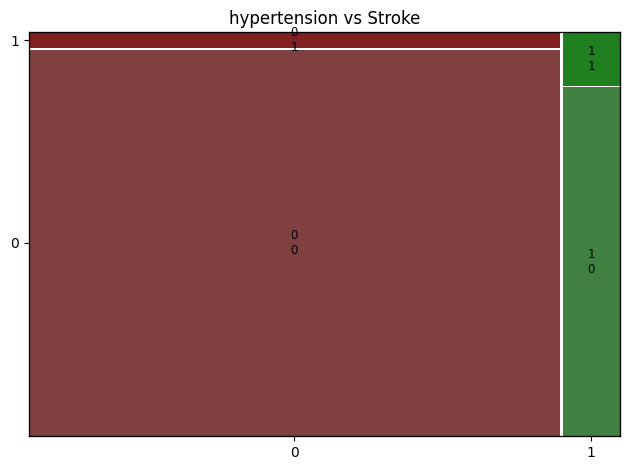

<Figure size 500x400 with 0 Axes>

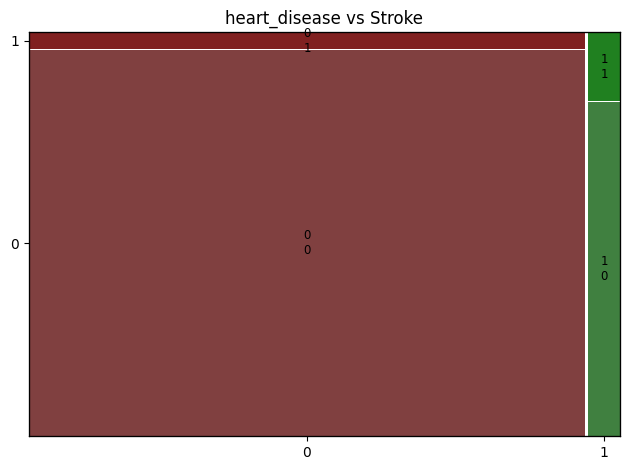

<Figure size 500x400 with 0 Axes>

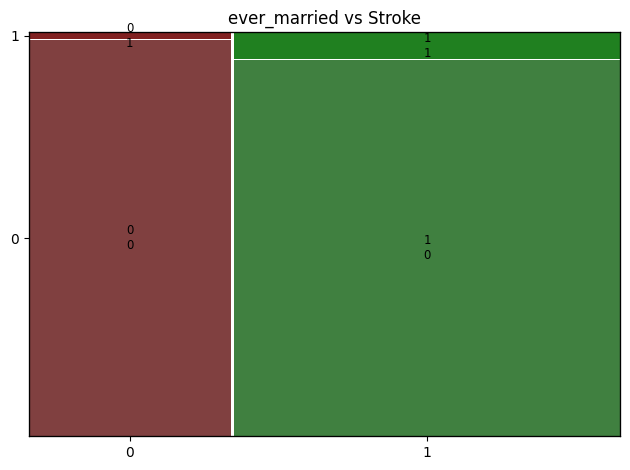

<Figure size 500x400 with 0 Axes>

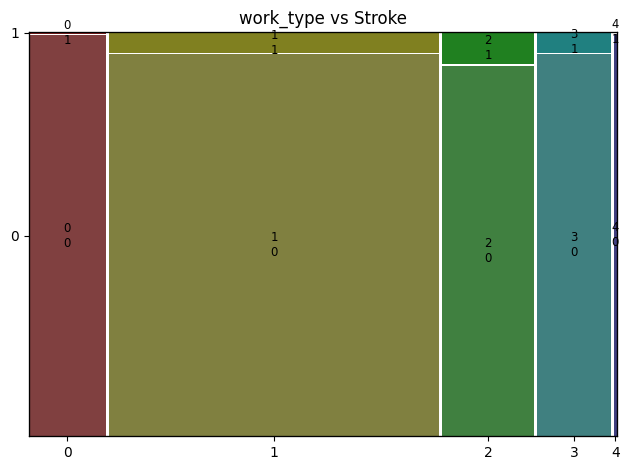

<Figure size 500x400 with 0 Axes>

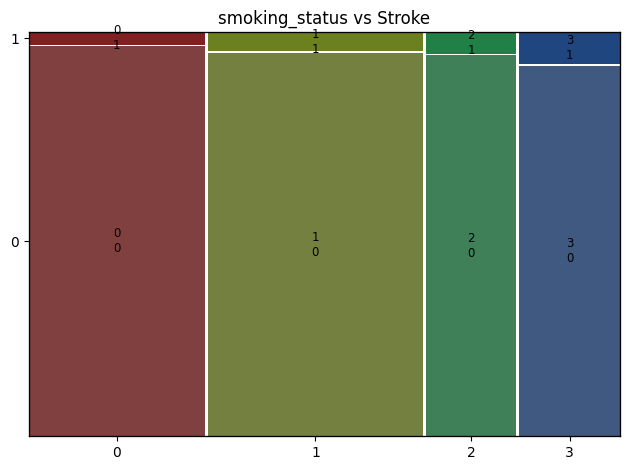

In [27]:
Y = 'stroke'
plot_X = [
    'hypertension',
    'heart_disease',
    'ever_married',
    'work_type',
    'smoking_status'
]

for X in plot_X:
    ct = pd.crosstab(df[X], df[Y])

    plt.figure(figsize=(5, 4))
    mosaic(ct.stack(), title=f'{X} vs Stroke')
    plt.tight_layout()
    plt.show()

---
## 로지스틱

In [28]:
# 변수 정의
cols = [
    'stroke',
    'hypertension',
    'heart_disease',
    'ever_married',
    'smoking_status',
    'age',
    'avg_glucose_level',
    'bmi'
]

df_logit = df[cols].dropna() # 결측 제거 

# 문자 → 숫자(정수형 변환)
df_logit['ever_married'] = df_logit['ever_married'].astype(int)
df_logit['stroke'] = df_logit['stroke'].astype(int)

# 더미화
df_logit = pd.get_dummies(
    df_logit,
    columns=['smoking_status'],
    drop_first=True
)

Y = df_logit['stroke']
X = df_logit.drop(columns='stroke')

# intercept 추가
X = sm.add_constant(X)

# dtype 정리
Y = Y.astype(int)
X = X.astype(float)

logit_model = sm.Logit(Y, X) # 로지스틱 회귀 모형 객체 생성
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.155359
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                 stroke   No. Observations:                 5110
Model:                          Logit   Df Residuals:                     5100
Method:                           MLE   Df Model:                            9
Date:                Wed, 17 Dec 2025   Pseudo R-squ.:                  0.2023
Time:                        10:03:11   Log-Likelihood:                -793.88
converged:                       True   LL-Null:                       -995.19
Covariance Type:            nonrobust   LLR p-value:                 3.804e-81
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -7.3827      0.528    -13.980      0.000      -8.418      -6.348
hyperten

- 모델 적합 문제 없음   
Optimization terminated successfully.  
converged: True

- Pseudo R² (모델의 상대적 적합도)
Pseudo R² (McFadden)  
0.10–0.20	양호  
0.20–0.40	매우 좋음  
-> 아무 변수도 안 썼을 때보다, 지금 이 변수들이 stroke 예측을 얼마나 개선했는가

| 변수                    |    coef |           OR (≈) | p-value | 해석              |
| --------------------- | ------: | ---------------: | ------: | --------------- |
| **age**               |  0.0704 |  **1.073 / 1년↑** |  <0.001 | **가장 강력한 위험요인** |
| **avg_glucose_level** |  0.0042 | **1.004 / 1단위↑** |  <0.001 | 혈당 증가 시 위험 증가   |
| **hypertension**      |  0.3954 |         **1.49** |   0.016 | 고혈압 보유 시 위험 ↑   |
| heart_disease         |  0.2917 |             1.34 |   0.123 | 보정 후 유의하지 않음    |
| ever_married          | -0.1998 |             0.82 |   0.362 | 독립적 영향 없음       |
| bmi                   | -0.0003 |             1.00 |   0.981 | 효과 없음           |
| smoking_status_1      | -0.1609 |             0.85 |   0.411 | 유의하지 않음         |
| smoking_status_2      |  0.1633 |             1.18 |   0.479 | 유의하지 않음         |
| smoking_status_3      |  0.0509 |             1.05 |   0.805 | 유의하지 않음         |


---
### VIF 

In [29]:
# 다중공산성 확인 
# intercept 제외
X_vif = X.drop(columns='const')

vif_df = pd.DataFrame({
    'Variable': X_vif.columns,
    'VIF': [
        variance_inflation_factor(X_vif.values, i)
        for i in range(X_vif.shape[1])
    ]
})

vif_df

,Variable,VIF
0,hypertension,1.197820
1,heart_disease,1.160809
2,ever_married,5.585984
3,age,10.229908
4,avg_glucose_level,6.035100
5,bmi,9.047170
6,smoking_status_1,2.508175
7,smoking_status_2,1.650437
8,smoking_status_3,1.846457


| 변수                    |       VIF | 해석              |
| --------------------- | --------: | --------------- |
| hypertension          |      1.20 | 문제 없음           |
| heart_disease         |      1.16 | 문제 없음           |
| smoking_status_1      |      2.51 | 약한 공선성          |
| smoking_status_2      |      1.65 | 문제 없음           |
| smoking_status_3      |      1.85 | 문제 없음           |
| **ever_married**      |  **5.59** | **중등도 공선성**     |
| **avg_glucose_level** |  **6.04** | **중등도 공선성**     |
| **bmi**               |  **9.05** | **높은 공선성 (경계)** |
| **age**               | **10.23** | **심각 (조치 필요)**  |


In [30]:
# 변수 정의 (ever_married 제거)
cols = [
    'stroke',
    'hypertension',
    'heart_disease',
    'smoking_status',
    'age',
    'avg_glucose_level',
    'bmi'
]

df_logit = df[cols].dropna()

# 문자 → 숫자
df_logit['stroke'] = df_logit['stroke'].astype(int)

# BMI 범주화
df_logit['bmi_cat'] = pd.cut(
    df_logit['bmi'],
    bins=[0, 18.5, 25, 30, float('inf')],
    labels=['Underweight', 'Normal', 'Overweight', 'Obese'],
    right=False
)

# 기존 bmi 제거
df_logit = df_logit.drop(columns='bmi')

# 더미화 (기준범주 자동 설정)
df_logit = pd.get_dummies(
    df_logit,
    columns=['smoking_status', 'bmi_cat'],
    drop_first=True
)

# 종속 / 독립 변수
Y = df_logit['stroke']
X = df_logit.drop(columns='stroke')

# intercept 추가
X = sm.add_constant(X)

# dtype 정리
X = X.astype(float)
Y = Y.astype(int)

# 로지스틱 회귀
logit_model = sm.Logit(Y, X)
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.154762
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                 stroke   No. Observations:                 5110
Model:                          Logit   Df Residuals:                     5099
Method:                           MLE   Df Model:                           10
Date:                Wed, 17 Dec 2025   Pseudo R-squ.:                  0.2053
Time:                        10:03:11   Log-Likelihood:                -790.83
converged:                       True   LL-Null:                       -995.19
Covariance Type:            nonrobust   LLR p-value:                 1.318e-81
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -8.5540      1.085     -7.882      0.000     -10.681      -6.427
hype

In [31]:
# 다중공산성 확인 
# intercept 제외
X_vif = X.drop(columns='const')

vif_df = pd.DataFrame({
    'Variable': X_vif.columns,
    'VIF': [
        variance_inflation_factor(X_vif.values, i)
        for i in range(X_vif.shape[1])
    ]
})

vif_df

,Variable,VIF
0,hypertension,1.217381
1,heart_disease,1.149867
2,age,7.470155
3,avg_glucose_level,5.567914
4,smoking_status_1,2.574880
5,smoking_status_2,1.674113
6,smoking_status_3,1.859384
7,bmi_cat_Normal,2.595477
8,bmi_cat_Overweight,4.226784
9,bmi_cat_Obese,5.100759


In [32]:
# 사용 변수 (ever_married 제거, bmi 연속형 유지)
cols = [
    'stroke',
    'hypertension',
    'heart_disease',
    'smoking_status',
    'age',
    'avg_glucose_level',
    'bmi'
]

# 결측 제거
df_logit = df[cols].dropna()

# dtype 정리
df_logit['stroke'] = df_logit['stroke'].astype(int)

# smoking_status 더미화 (기준범주 자동 설정)
df_logit = pd.get_dummies(
    df_logit,
    columns=['smoking_status'],
    drop_first=True
)

# 종속 / 독립 변수
Y = df_logit['stroke']
X = df_logit.drop(columns='stroke')

# intercept 추가
X = sm.add_constant(X)

# 타입 통일
X = X.astype(float)
Y = Y.astype(int)

# 로지스틱 회귀 적합
logit_model = sm.Logit(Y, X)
result = logit_model.fit()

# 결과 출력
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.155437
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                 stroke   No. Observations:                 5110
Model:                          Logit   Df Residuals:                     5101
Method:                           MLE   Df Model:                            8
Date:                Wed, 17 Dec 2025   Pseudo R-squ.:                  0.2019
Time:                        10:03:11   Log-Likelihood:                -794.28
converged:                       True   LL-Null:                       -995.19
Covariance Type:            nonrobust   LLR p-value:                 7.706e-82
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -7.4844      0.524    -14.294      0.000      -8.511      -6.458
hyperten

In [33]:
# 다중공산성 확인 
# intercept 제외
X_vif = X.drop(columns='const')

vif_df = pd.DataFrame({
    'Variable': X_vif.columns,
    'VIF': [
        variance_inflation_factor(X_vif.values, i)
        for i in range(X_vif.shape[1])
    ]
})

vif_df

,Variable,VIF
0,hypertension,1.196879
1,heart_disease,1.154581
2,age,6.641139
3,avg_glucose_level,6.014052
4,bmi,8.953646
5,smoking_status_1,2.500709
6,smoking_status_2,1.637490
7,smoking_status_3,1.841367


In [34]:
# 회귀 결과에서 OR 테이블 생성
params = result.params
conf = result.conf_int()
conf.columns = ['CI_lower', 'CI_upper']

or_table = pd.DataFrame({
    'Variable': params.index,
    'Coef': params.values,
    'OR': np.exp(params.values),
    'CI_lower': np.exp(conf['CI_lower']),
    'CI_upper': np.exp(conf['CI_upper']),
    'p_value': result.pvalues.values
})

# intercept 제거
or_table = or_table[or_table['Variable'] != 'const']

# 보기 좋게 정렬
or_table = or_table.sort_values('OR', ascending=False).reset_index(drop=True)

or_table


,Variable,Coef,OR,CI_lower,CI_upper,p_value
0,hypertension,0.396750,1.486985,1.077782,2.051548,1.568674e-02
1,heart_disease,0.299782,1.349565,0.931730,1.954778,1.127651e-01
2,smoking_status_2,0.155430,1.168160,0.743963,1.834229,4.995612e-01
3,age,0.069510,1.071983,1.060930,1.083150,1.796884e-39
4,smoking_status_3,0.043375,1.044330,0.697517,1.563580,8.331706e-01
5,avg_glucose_level,0.004144,1.004152,1.001816,1.006494,4.897692e-04
6,bmi,-0.000649,0.999351,0.977702,1.021480,9.536895e-01
7,smoking_status_1,-0.161986,0.850453,0.579641,1.247792,4.075768e-01


| 변수                                            | 해석                                                                  |
| --------------------------------------------- | ------------------------------------------------------------------- |
| **age** (OR = 1.072, p < 0.001)               | 나이 **1세 증가 시 stroke 위험 약 7.2% 증가**. 가장 강력하고 안정적인 예측 변수.             |
| **hypertension** (OR = 1.49, p < 0.05)       | 고혈압 보유자는 비보유자 대비 **stroke 위험 약 49% 증가**. age·대사요인 보정 후에도 독립적 효과 유지. |
| **avg_glucose_level** (OR = 1.004, p < 0.001) | 혈당 **1 mg/dL 증가당 위험 0.4% 증가**. 작은 효과지만 누적 시 임상적으로 의미 있음.            |
| heart_disease (OR = 1.35, p > 0.05)          | 위험 증가 방향성은 있으나 **통계적으로 유의하지 않음**. age·고혈압에 의해 효과가 상당 부분 설명됨.        |
| bmi (OR ≈ 1.00, p > 0.05)                    | stroke에 대한 **독립 효과 없음**. 조정 변수(confounder) 역할.                      |
| smoking_status_1 (OR = 0.85, p > 0.05)        | 보호 방향이지만 **유의하지 않음**.                                               |
| smoking_status_2 (OR = 1.17, p > 0.05)        | 위험 증가 방향이나 **불확실**.                                                 |
| smoking_status_3 (OR = 1.04, p > 0.05)        | 효과 거의 없음.                                                           |


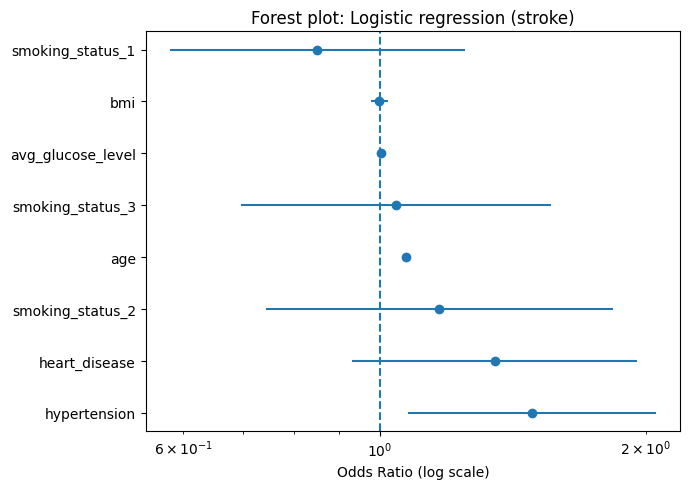

In [35]:
# plotting용 데이터
plot_df = or_table.copy()

y_pos = np.arange(len(plot_df))

plt.figure(figsize=(7, 5))
plt.errorbar(
    plot_df['OR'],
    y_pos,
    xerr=[
        plot_df['OR'] - plot_df['CI_lower'],
        plot_df['CI_upper'] - plot_df['OR']
    ],
    fmt='o'
)

plt.axvline(x=1, linestyle='--')
plt.yticks(y_pos, plot_df['Variable'])
plt.xlabel('Odds Ratio (log scale)')
plt.xscale('log')
plt.title('Forest plot: Logistic regression (stroke)')
plt.tight_layout()
plt.show()


---
## 로지스틱 예측 모델

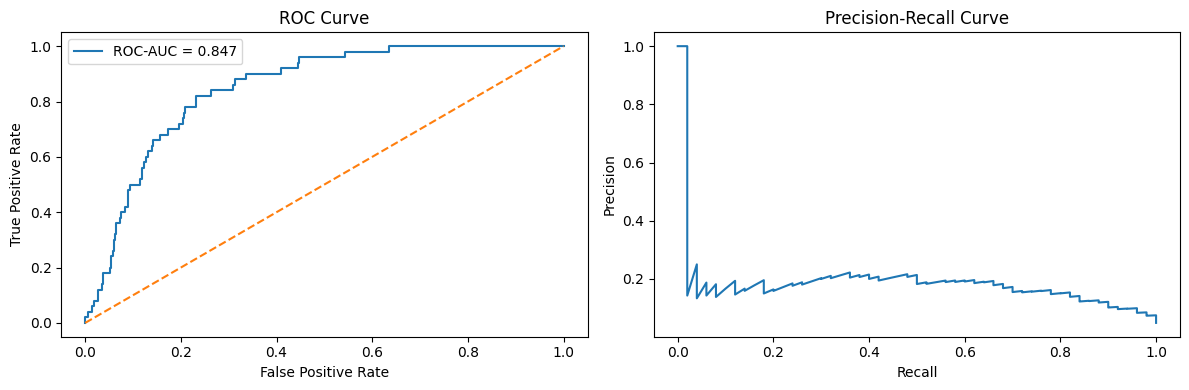

Best threshold (F1): 0.739
Best threshold (Youden J): 0.574

Confusion Matrix
[[746 226]
 [ 10  40]]

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.77      0.86       972
           1       0.15      0.80      0.25        50

    accuracy                           0.77      1022
   macro avg       0.57      0.78      0.56      1022
weighted avg       0.95      0.77      0.83      1022


Final ROC-AUC: 0.847


In [36]:
# 1. 데이터 준비
features = [
    'hypertension',
    'heart_disease',
    'age',
    'avg_glucose_level',
    'bmi',
    'smoking_status_1',
    'smoking_status_2',
    'smoking_status_3'
]

X = df_logit[features]
y = df_logit['stroke']

# 8:2 stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, # 80:20 
    stratify=y,
    random_state=42
)

# 2. 스케일링
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# 3. 로지스틱 모델 학습
clf = LogisticRegression(
    penalty='l2',               # 규제 방식: L2
    C=1.0,                      # 규제 강도 (작을수록 규제 올라감)
    solver='liblinear',         # 최적화 알고리즘
    class_weight='balanced',    # 클래스 불균형 보정 (소수 클래스 가중 높임)
    max_iter=1000               # 최대 반복 수
)

clf.fit(X_train_s, y_train)

# 4. 예측 확률
y_prob = clf.predict_proba(X_test_s)[:, 1]

# 5. ROC / PR 평가
roc_auc = roc_auc_score(y_test, y_prob)

fpr, tpr, roc_th = roc_curve(y_test, y_prob)
prec, rec, pr_th = precision_recall_curve(y_test, y_prob)

# 가로 배치
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# ROC Curve
axes[0].plot(fpr, tpr, label=f'ROC-AUC = {roc_auc:.3f}')
axes[0].plot([0, 1], [0, 1], '--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend()

# PR Curve
axes[1].plot(rec, prec)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')

plt.tight_layout()
plt.show()
# 6. Threshold 최적화
# (1) F1 기준
ths = np.linspace(0.01, 0.99, 200)
f1s = [f1_score(y_test, (y_prob > t).astype(int)) for t in ths]
best_thr_f1 = ths[np.argmax(f1s)]

# (2) Youden J 기준
J = tpr - fpr
best_thr_J = roc_th[np.argmax(J)]

print(f"Best threshold (F1): {best_thr_f1:.3f}")
print(f"Best threshold (Youden J): {best_thr_J:.3f}")

# 7. 최적 threshold 적용 결과
y_pred_opt = (y_prob > best_thr_J).astype(int)

print("\nConfusion Matrix")
print(confusion_matrix(y_test, y_pred_opt))

print("\nClassification Report")
print(classification_report(y_test, y_pred_opt))

# 8. 요약 출력
print(f"\nFinal ROC-AUC: {roc_auc:.3f}")

분별력: ROC-AUC 0.847 → 예측 구분 능력 우수  
threshold: Youden J(0.574) 선택 → 민감도 우선  
결과: stroke 놓침 최소화, 대신 오탐 증가  

Recall(양성)=0.80: stroke의 80% 탐지  
FN=10: 놓친 환자 소수  
FP=226  

- 튜닝 일부 진행

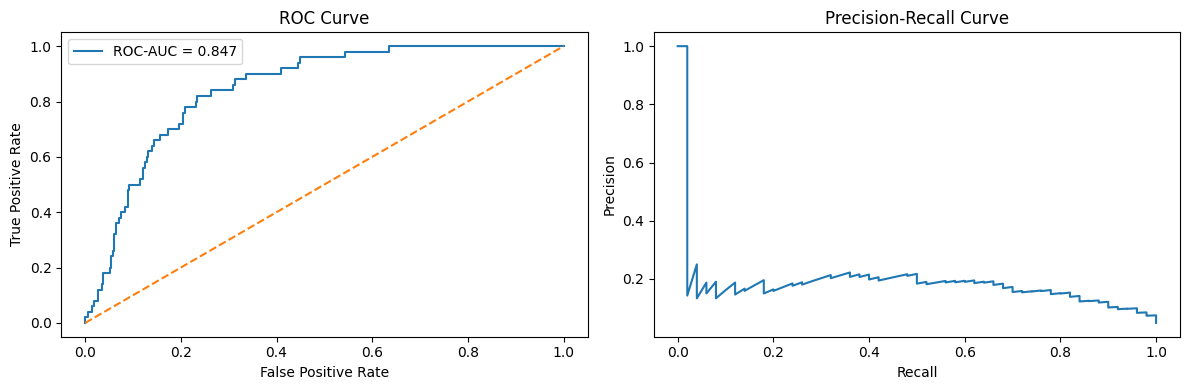

Best threshold (F1): 0.788
Best threshold (Youden J): 0.574

Confusion Matrix
[[745 227]
 [ 10  40]]

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.77      0.86       972
           1       0.15      0.80      0.25        50

    accuracy                           0.77      1022
   macro avg       0.57      0.78      0.56      1022
weighted avg       0.95      0.77      0.83      1022


Final ROC-AUC: 0.847


In [37]:
# 1. 데이터 준비
features = [
    'hypertension',
    'heart_disease',
    'age',
    'avg_glucose_level',
    'bmi',
    'smoking_status_1',
    'smoking_status_2',
    'smoking_status_3'
]

X = df_logit[features]
y = df_logit['stroke']

# 8:2 stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 2. 스케일링
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# 3. 로지스틱 모델 학습
clf = LogisticRegression(
    penalty='l2',
    C=0.3,                  # C 값을 낮춰 recall 향상 기대
    solver='liblinear',     
    class_weight='balanced',
    max_iter=2000           # 1000 -> 2000 
)

clf.fit(X_train_s, y_train)

# 4. 예측 확률
y_prob = clf.predict_proba(X_test_s)[:, 1]

# 5. ROC / PR 평가
roc_auc = roc_auc_score(y_test, y_prob)

fpr, tpr, roc_th = roc_curve(y_test, y_prob)
prec, rec, pr_th = precision_recall_curve(y_test, y_prob)

# 가로 배치
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# ROC Curve
axes[0].plot(fpr, tpr, label=f'ROC-AUC = {roc_auc:.3f}')
axes[0].plot([0, 1], [0, 1], '--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend()

# PR Curve
axes[1].plot(rec, prec)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')

plt.tight_layout()
plt.show()
# 6. Threshold 최적화
# (1) F1 기준
ths = np.linspace(0.01, 0.99, 200)
f1s = [f1_score(y_test, (y_prob > t).astype(int)) for t in ths]
best_thr_f1 = ths[np.argmax(f1s)]

# (2) Youden J 기준
J = tpr - fpr
best_thr_J = roc_th[np.argmax(J)]

print(f"Best threshold (F1): {best_thr_f1:.3f}")
print(f"Best threshold (Youden J): {best_thr_J:.3f}")

# 7. 최적 threshold 적용 결과
y_pred_opt = (y_prob > best_thr_J).astype(int)

print("\nConfusion Matrix")
print(confusion_matrix(y_test, y_pred_opt))

print("\nClassification Report")
print(classification_report(y_test, y_pred_opt))

# 8. 요약 출력
print(f"\nFinal ROC-AUC: {roc_auc:.3f}")

성능 동일  
-> SMOTE 적용 

Before SMOTE: [3889  199]
After  SMOTE: [3889 3889]


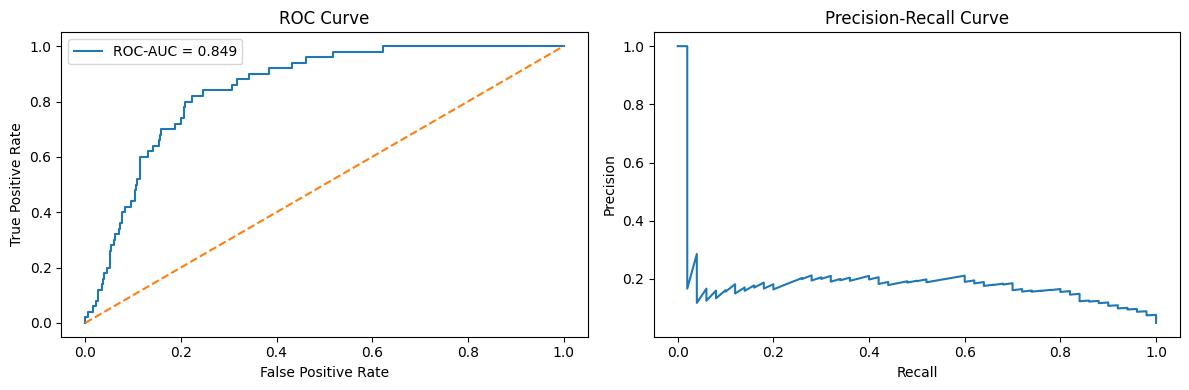

Best threshold (F1): 0.768
Best threshold (Youden J): 0.592

Confusion Matrix
[[754 218]
 [ 10  40]]

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.78      0.87       972
           1       0.16      0.80      0.26        50

    accuracy                           0.78      1022
   macro avg       0.57      0.79      0.56      1022
weighted avg       0.95      0.78      0.84      1022


Final ROC-AUC: 0.849


In [38]:
# 1. 데이터 준비
features = [
    'hypertension',
    'heart_disease',
    'age',
    'avg_glucose_level',
    'bmi',
    'smoking_status_1',
    'smoking_status_2',
    'smoking_status_3'
]

X = df_logit[features]
y = df_logit['stroke']

# 8:2 stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 2. 스케일링 (SMOTE 전에)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# 3. SMOTE (train data에서만)
smote = SMOTE(
    sampling_strategy=1.0,   # minority = majority
    k_neighbors=5,
    random_state=42
)

X_train_sm, y_train_sm = smote.fit_resample(X_train_s, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After  SMOTE:", np.bincount(y_train_sm))

# 4. 로지스틱 모델 학습
clf = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='liblinear',
    max_iter=1000
)

clf.fit(X_train_sm, y_train_sm)

# 5. 예측 확률
y_prob = clf.predict_proba(X_test_s)[:, 1]

# 6. ROC / PR 평가
roc_auc = roc_auc_score(y_test, y_prob)

fpr, tpr, roc_th = roc_curve(y_test, y_prob)
prec, rec, pr_th = precision_recall_curve(y_test, y_prob)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# ROC
axes[0].plot(fpr, tpr, label=f'ROC-AUC = {roc_auc:.3f}')
axes[0].plot([0, 1], [0, 1], '--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend()

# PR
axes[1].plot(rec, prec)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

# 7. Threshold 최적화
ths = np.linspace(0.01, 0.99, 200)

# (1) F1 기준
f1s = [f1_score(y_test, (y_prob > t).astype(int)) for t in ths]
best_thr_f1 = ths[np.argmax(f1s)]

# (2) Youden J
J = tpr - fpr
best_thr_J = roc_th[np.argmax(J)]

print(f"Best threshold (F1): {best_thr_f1:.3f}")
print(f"Best threshold (Youden J): {best_thr_J:.3f}")

# 8. 최적 threshold 적용
y_pred_opt = (y_prob > best_thr_J).astype(int)

print("\nConfusion Matrix")
print(confusion_matrix(y_test, y_pred_opt))

print("\nClassification Report")
print(classification_report(y_test, y_pred_opt))

print(f"\nFinal ROC-AUC: {roc_auc:.3f}")

precision 0.01 향상, f1-score 0.01 증가
accuracy - 0.01  

-> SMOTE 적용 수치로 시각화(Confusion matrix)

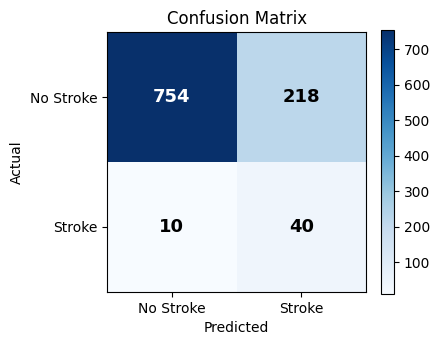

In [39]:
cm = confusion_matrix(y_test, y_pred_opt)

fig, ax = plt.subplots(figsize=(4.5, 4.5))
im = ax.imshow(cm, cmap='Blues')

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['No Stroke', 'Stroke'])
ax.set_yticklabels(['No Stroke', 'Stroke'])

for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j],
                ha='center', va='center',
                fontsize=13, fontweight='bold',
                color='white' if cm[i, j] > cm.max()/2 else 'black')

plt.colorbar(im, ax=ax, fraction=0.046)
plt.tight_layout()
plt.show()

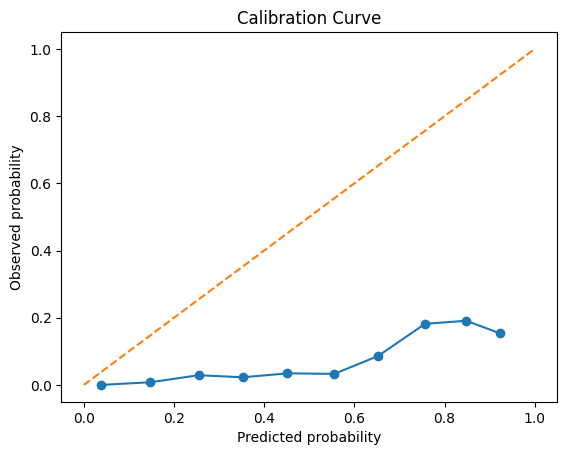

In [40]:
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1], [0,1], '--')
plt.xlabel('Predicted probability')
plt.ylabel('Observed probability')
plt.title('Calibration Curve')
plt.show()

---
## 다른 모델 적용
1. RandomForest

In [58]:
features = [
    'hypertension',
    'heart_disease',
    'age',
    'avg_glucose_level',
    'bmi',
    'smoking_status_1',
    'smoking_status_2',
    'smoking_status_3'
]

X = df_logit[features]
y = df_logit['stroke']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

rf_base = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

param_dist = {
    'n_estimators': [300, 500, 700, 900], # 트리 수 (성능 안정 및 계산량 결정)
    'max_depth': [None, 6, 8, 10, 12],    # 트리 최대 깊이 
    'min_samples_split': [2, 5, 10],      # 노드 분할 최소 샘플 수 
    'min_samples_leaf': [1, 3, 5, 10],    # 리프 노드에 남아야 하는 샘플 수 
    'max_features': ['sqrt', 'log2']      # 각 분기 고려 feature 수 
}

# StratifiedKFold: 각 fold 마다 클래스 비율 동일 유지 
# n_splits: 5-fold 교차 검증 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rs = RandomizedSearchCV(
    estimator=rf_base,              # 튜닝 대상 모델
    param_distributions=param_dist, # 정의 탐색 공간
    n_iter=30,                      # 전체 무작위로 30개 조합 평가
    scoring='roc_auc',              # 불균형 데이터 기준
    cv=cv,                          
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rs.fit(X_train, y_train)

best_rf = rs.best_estimator_
print("Best params:", rs.best_params_)
print("CV ROC-AUC:", rs.best_score_)

proba_test = best_rf.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, proba_test)
print("Test ROC-AUC:", roc_auc)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': None}
CV ROC-AUC: 0.8416972478990473
Test ROC-AUC: 0.8414403292181071


In [59]:
thresholds = np.linspace(0.01, 0.9, 300)
f1_scores = [f1_score(y_test, (proba_test >= t).astype(int)) for t in thresholds]

best_f1_idx = np.argmax(f1_scores)
best_threshold_f1 = thresholds[best_f1_idx]

print("Best threshold (F1):", best_threshold_f1)
print("Best F1:", f1_scores[best_f1_idx])

fpr, tpr, thr = roc_curve(y_test, proba_test)
youden_j = tpr - fpr
best_j_idx = np.argmax(youden_j)
best_threshold_j = thr[best_j_idx]

print("Best threshold (Youden J):", best_threshold_j)

# F1 기준 threshold 적용
y_pred = (proba_test >= best_threshold_j).astype(int)

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report")
print(classification_report(y_test, y_pred, digits=3))

Best threshold (F1): 0.4475585284280936
Best F1: 0.2857142857142857
Best threshold (Youden J): 0.28904281337532295
Confusion Matrix
[[731 241]
 [  8  42]]

Classification Report
              precision    recall  f1-score   support

           0      0.989     0.752     0.854       972
           1      0.148     0.840     0.252        50

    accuracy                          0.756      1022
   macro avg      0.569     0.796     0.553      1022
weighted avg      0.948     0.756     0.825      1022



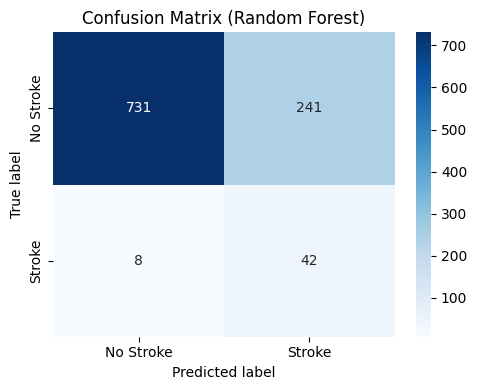

In [60]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['No Stroke', 'Stroke'],
    yticklabels=['No Stroke', 'Stroke']
)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Random Forest)')
plt.tight_layout()
plt.show()

In [44]:
importances = pd.Series(
    best_rf.feature_importances_,
    index=features
).sort_values(ascending=False)

importances

age                  0.519308
avg_glucose_level    0.197174
bmi                  0.187398
heart_disease        0.027643
hypertension         0.021181
smoking_status_1     0.020058
smoking_status_3     0.016171
smoking_status_2     0.011066
dtype: float64

In [45]:
pr_auc = average_precision_score(y_test, proba_test)
print("PR-AUC:", pr_auc)

PR-AUC: 0.17552038795559935


In [46]:
rf_base.fit(X_train, y_train)

r = permutation_importance(
    rf_base, X_test, y_test,
    scoring="roc_auc",
    n_repeats=10,
    random_state=42
)

pd.Series(r.importances_mean, index=X_test.columns)\
  .sort_values(ascending=False)


age                  0.213465
avg_glucose_level    0.007986
hypertension         0.005290
smoking_status_2     0.001343
bmi                 -0.003834
heart_disease       -0.005827
smoking_status_1    -0.009292
smoking_status_3    -0.010638
dtype: float64

---
## LightGBM 

In [ ]:
# 변수 설정 
features = [
    'hypertension',
    'heart_disease',
    'age',
    'avg_glucose_level',
    'bmi',
    'smoking_status_1',
    'smoking_status_2',
    'smoking_status_3'
]

X = df_logit[features]
y = df_logit['stroke']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
pos_weight

np.float64(19.542713567839197)

In [ ]:
lgbm = LGBMClassifier(
    n_estimators=600,           # 트리 수 
    learning_rate=0.03,         # 트리 기여도 (0.03 = 보수적)
    num_leaves=31,              # 최대 리프 수
    max_depth=-1,               # 깊이 제한 없음 
    min_child_samples=20,       # 리프 노드 최소 샘플 수 
    subsample=0.8,              # 80% (행)
    colsample_bytree=0.8,       # 80% (열)
    scale_pos_weight=pos_weight,# stroke = 1 에 가중치 부여 
    random_state=42,    
    n_jobs=-1
)

lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 199, number of negative: 3889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 622
[LightGBM] [Info] Number of data points in the train set: 4088, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.048679 -> initscore=-2.972603
[LightGBM] [Info] Start training from score -2.972603


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.03
,n_estimators,600
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [62]:
pred_prob = lgbm.predict_proba(X_test)[:, 1]

In [ ]:
thresholds = np.linspace(0.05, 0.9, 200) # 0.05 ~ 0.9를 200개로 균등 분할 
f1_scores = []

for t in thresholds:
    preds = (pred_prob >= t).astype(int)
    f1_scores.append(f1_score(y_test, preds))

best_threshold = thresholds[np.argmax(f1_scores)]
best_threshold

np.float64(0.07135678391959799)

In [64]:
pred_label_opt = (pred_prob >= best_threshold).astype(int)

print("Best threshold:", best_threshold)
print("ROC-AUC:", roc_auc_score(y_test, pred_prob))
print(confusion_matrix(y_test, pred_label_opt))
print(classification_report(y_test, pred_label_opt))

Best threshold: 0.07135678391959799
ROC-AUC: 0.8104732510288065
[[793 179]
 [ 17  33]]
              precision    recall  f1-score   support

           0       0.98      0.82      0.89       972
           1       0.16      0.66      0.25        50

    accuracy                           0.81      1022
   macro avg       0.57      0.74      0.57      1022
weighted avg       0.94      0.81      0.86      1022



성능이 좋지 않은 모습..

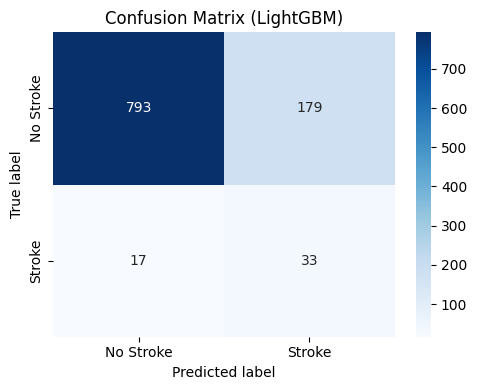

In [66]:
cm = confusion_matrix(y_test, pred_label_opt)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['No Stroke', 'Stroke'],
    yticklabels=['No Stroke', 'Stroke']
)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (LightGBM)')
plt.tight_layout()
plt.show()

c:\Users\KDT_05\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\explainers\_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


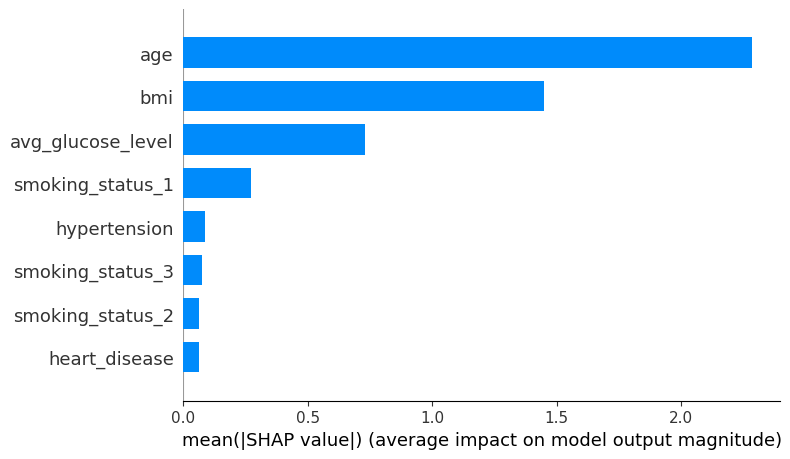

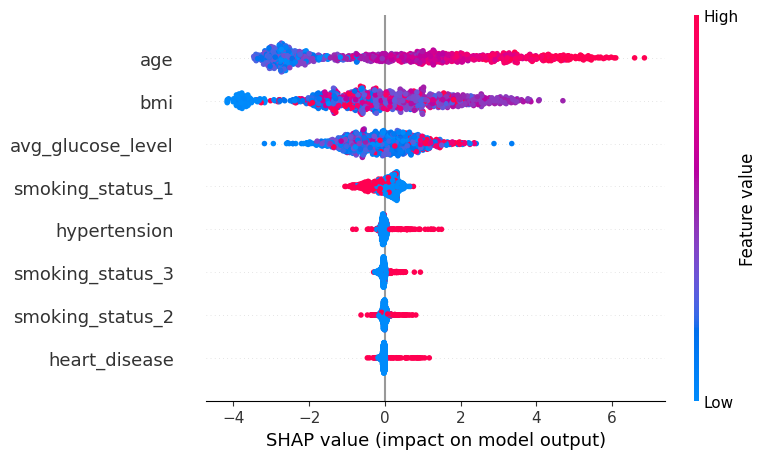

In [54]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_test)

# summary plot (bar)
shap.summary_plot(
    shap_values,
    X_test,
    plot_type="bar",
    max_display=10
)

# summary plot (distribution)
shap.summary_plot(
    shap_values,
    X_test,
    max_display=10
)

- mean(|SHAP value|) = 모델 출력에 미치는 평균 영향 크기 순위
-> age > bmi > avg_glucose > smoking_status 순위  

- SHAP value (summary plot) = 방향성 및 분포 확인
-> age: 나이가 많을수록 뇌졸중 위험 확률 증가  
-> bmi: bmi 높을수록 SHAP값이 양수 인 것 처럼 느껴짐 (주관적 해석)

---
## XGBoost

In [ ]:
# 1. Data split
features = [
    'hypertension', 'heart_disease', 'age',
    'avg_glucose_level', 'bmi',
    'smoking_status_1', 'smoking_status_2', 'smoking_status_3'
]

X = df_logit[features]
y = df_logit['stroke']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 2. Class imbalance weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print("scale_pos_weight:", scale_pos_weight)

# 3. Base XGB model (SHAP-safe)
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight,
    base_score=0.5,          # SHAP 핵심
    tree_method='hist',
    random_state=42,
    n_jobs=-1
)

# 4. Hyperparameter search space
param_dist = {
    'n_estimators': [400, 600, 800, 1000],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [3, 4, 5],
    'min_child_weight': [3, 5, 10],
    'gamma': [0, 0.3, 0.5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [1, 2, 3]
}

# 5. CV optimization (ROC-AUC)
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

rs = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,
    scoring='roc_auc',
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rs.fit(X_train, y_train)
best_model = rs.best_estimator_

print("Best CV ROC-AUC:", rs.best_score_)
print("Best params:", rs.best_params_)

# 6. Probability prediction
y_prob = best_model.predict_proba(X_test)[:, 1]

# 7. Threshold optimization
# --- Youden J ---
fpr, tpr, thr_roc = roc_curve(y_test, y_prob)
youden_j = tpr - fpr
best_thr_j = thr_roc[np.argmax(youden_j)]

# --- F1 ---
prec, rec, thr_pr = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-9)
best_thr_f1 = thr_pr[np.argmax(f1_scores)]

print(f"Best threshold (Youden J): {best_thr_j:.3f}")
print(f"Best threshold (F1): {best_thr_f1:.3f}")

# thr 선택 
thr = best_thr_j

# 8. Final evaluation
y_pred = (y_prob >= thr).astype(int)

print("\nROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nConfusion Matrix\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report\n", classification_report(y_test, y_pred))

scale_pos_weight: 19.542713567839197
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best CV ROC-AUC: 0.8402166759686039
Best params: {'subsample': 0.7, 'reg_lambda': 3, 'reg_alpha': 1, 'n_estimators': 400, 'min_child_weight': 10, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}
Best threshold (Youden J): 0.483
Best threshold (F1): 0.612

ROC-AUC: 0.8373868312757201

Confusion Matrix
 [[727 245]
 [  9  41]]

Classification Report
               precision    recall  f1-score   support

           0       0.99      0.75      0.85       972
           1       0.14      0.82      0.24        50

    accuracy                           0.75      1022
   macro avg       0.57      0.78      0.55      1022
weighted avg       0.95      0.75      0.82      1022



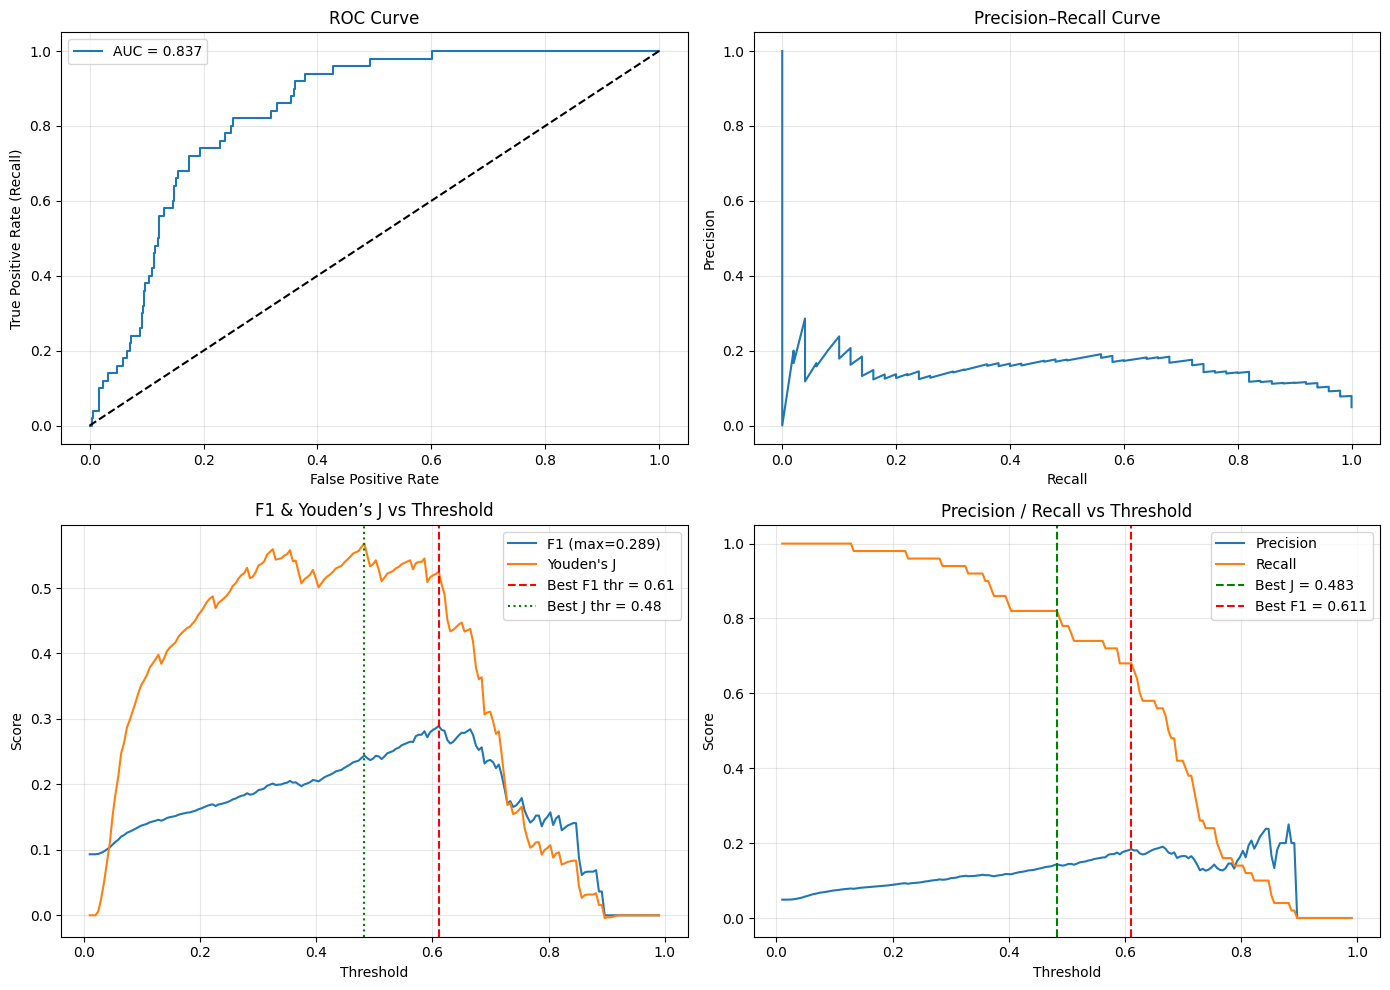

In [ ]:
# ROC
fpr, tpr, roc_thr = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# PR
prec, rec, pr_thr = precision_recall_curve(y_test, y_prob)

# threshold grid
thresholds = np.linspace(0.01, 0.99, 200)

P, R, F1, J = [], [], [], []

for t in thresholds:
    y_hat = (y_prob >= t).astype(int)

    p = precision_score(y_test, y_hat, zero_division=0)
    r = recall_score(y_test, y_hat)
    f1 = f1_score(y_test, y_hat, zero_division=0)

    tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
    spec = tn / (tn + fp + 1e-9)
    j = r + spec - 1

    P.append(p); R.append(r); F1.append(f1); J.append(j)

P, R, F1, J = map(np.array, (P, R, F1, J))

best_thr_f1 = thresholds[np.argmax(F1)]
best_thr_j  = thresholds[np.argmax(J)]
best_f1 = F1.max()

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- (1) ROC ---
axes[0, 0].plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
axes[0, 0].plot([0, 1], [0, 1], 'k--')
axes[0, 0].set_title("ROC Curve")
axes[0, 0].set_xlabel("False Positive Rate")
axes[0, 0].set_ylabel("True Positive Rate (Recall)")
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# --- (2) PR ---
axes[0, 1].plot(rec, prec)
axes[0, 1].set_title("Precision-Recall Curve")
axes[0, 1].set_xlabel("Recall")
axes[0, 1].set_ylabel("Precision")
axes[0, 1].grid(alpha=0.3)

# --- (3) F1 & Youden J vs Threshold ---
axes[1, 0].plot(thresholds, F1, label=f"F1 (max={best_f1:.3f})")
axes[1, 0].plot(thresholds, J, label="Youden's J")

axes[1, 0].axvline(
    best_thr_f1, color='r', linestyle='--',
    label=f"Best F1 thr = {best_thr_f1:.2f}"
)
axes[1, 0].axvline(
    best_thr_j, color='g', linestyle=':',
    label=f"Best J thr = {best_thr_j:.2f}"
)

axes[1, 0].set_title("F1 & Youden’s J vs Threshold")
axes[1, 0].set_xlabel("Threshold")
axes[1, 0].set_ylabel("Score")
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# --- (4) Precision / Recall vs Threshold ---
axes[1, 1].plot(thresholds, P, label="Precision")
axes[1, 1].plot(thresholds, R, label="Recall")
axes[1, 1].axvline(
    best_thr_j, color='g', linestyle='--',
    label=f"Best J = {best_thr_j:.3f}"
)
axes[1, 1].axvline(
    best_thr_f1, color='r', linestyle='--',
    label=f"Best F1 = {best_thr_f1:.3f}"
)
axes[1, 1].set_title("Precision / Recall vs Threshold")
axes[1, 1].set_xlabel("Threshold")
axes[1, 1].set_ylabel("Score")
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


- ROC Curve
AUC = 0.837  
threshold 전반에서 양성/음성 분리 능력 안정적     

- PR Curve  
Recall 증가 시 precision 급격히 감소  
양성 비율이 매우 낮기 때문 

- Threshold 
F1 score 최대 ≈ 0.289 / thr ≈ 0.61  
Youden’s J 최대 > 0.5 / thr ≈ 0.48

- Precision / Recall vs Threshold 
Threshold ↑  
-> Precision ↑ (하지만 한계 명확)  
-> Recall ↓ 급격  
thr ≈ 0.48 (J 기준)  
-> Recall 아직 높음  
-> Precision 극단적으로 붕괴되지 않음  
thr ≈ 0.61 (F1 기준)  
-> Recall 급감 → 놓치는 양성 증가

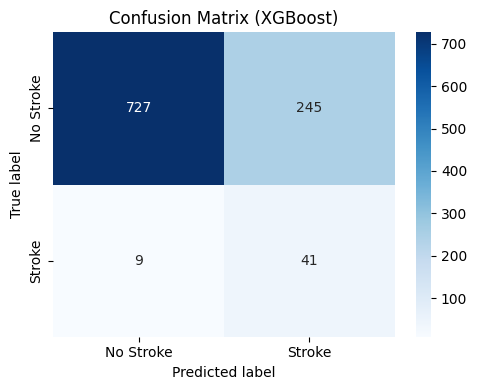

In [69]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['No Stroke', 'Stroke'],
    yticklabels=['No Stroke', 'Stroke']
)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (XGBoost)')
plt.tight_layout()
plt.show()

In [ ]:
# 9. Feature importance
importance = pd.Series(
    best_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

print("\nFeature Importance\n", importance)


Feature Importance
 age                  0.343968
heart_disease        0.135457
hypertension         0.116437
avg_glucose_level    0.113829
bmi                  0.103381
smoking_status_3     0.085283
smoking_status_1     0.060194
smoking_status_2     0.041451
dtype: float32


- age (0.344)

전체 중요도의 1/3 이상 차지  

연령 증가에 따른 위험 누적 효과 반영  

다른 변수들의 효과를 “증폭”시키는 기준축 역할  

- heart_disease (0.135)

기존 심혈관 질환 병력의 강한 예측력

이진 변수임에도 높은 중요도 → 신호 강함

- hypertension (0.116)

만성 위험요인으로서 안정적 기여

age 다음의 핵심 임상 변수

PermutationExplainer explainer: 1023it [01:13, 13.67it/s]                          
C:\Users\KDT_05\AppData\Local\Temp\ipykernel_7436\2208683751.py:19: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


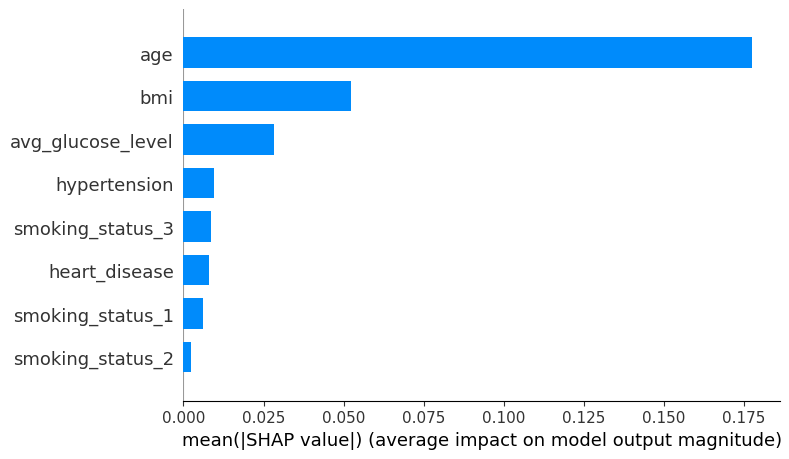

C:\Users\KDT_05\AppData\Local\Temp\ipykernel_7436\2208683751.py:30: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


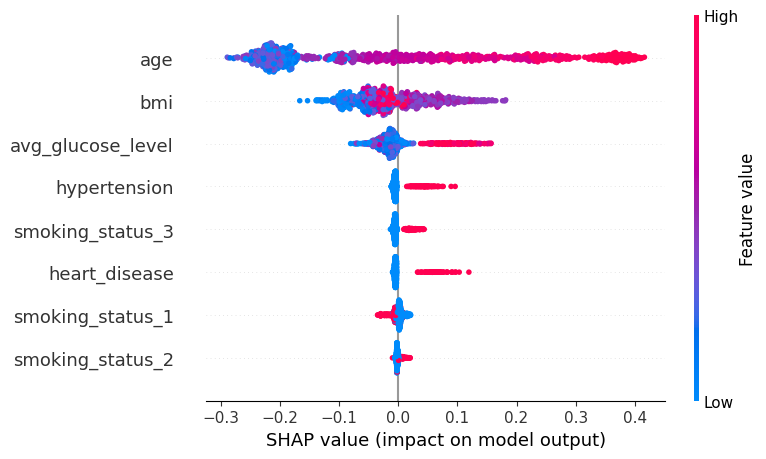

In [ ]:
# SHAP
X_train_shap = X_train.astype(float).values
X_test_shap  = X_test.astype(float).values

def xgb_predict(X):
    return best_model.predict_proba(X)[:, 1]

explainer = shap.Explainer(
    xgb_predict,
    X_train_shap,
    algorithm="permutation",
    rng=np.random.default_rng(42)   # FutureWarning 제거
)

shap_values = explainer(X_test_shap)

shap_values.feature_names = list(X_test.columns)

shap.summary_plot(
    shap_values,
    X_test,                 # DataFrame → 변수명 유지
    plot_type="bar",
    show=False
)

import matplotlib.pyplot as plt
plt.tight_layout()
plt.show()

shap.summary_plot(
    shap_values,
    X_test,
    show=False
)

plt.tight_layout()
plt.show()

- 방향성 제시: age·bmi·avg_glucose_level ↑ → 위험 증가

---
### 파생변수 생성 

In [22]:
df_co1 = df 

In [23]:
df_co1

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,38920,0,0.48,0,0,0,0,0,73.02,28.1,0,0
1,11658,0,1.08,0,0,0,0,1,74.50,28.1,0,0
2,69768,1,1.32,0,0,0,0,0,70.37,28.1,0,1
3,32147,0,1.32,0,0,0,0,1,107.02,28.1,0,0
4,32514,0,1.80,0,0,0,0,0,68.80,28.1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,45893,1,8.00,0,0,0,0,0,106.51,12.3,0,0
5106,20364,1,4.00,0,0,0,0,0,107.25,12.0,0,0
5107,59993,0,40.00,0,0,1,1,1,60.96,11.5,1,0
5108,3205,1,79.00,0,0,1,2,0,79.03,11.3,0,0


In [24]:
# 불필요 컬럼 제거
drop_cols = [
    "id",
    "gender",
    "ever_married",
    "work_type",
    "Residence_type"
]
df_co1 = df_co1.drop(columns=drop_cols, errors="ignore")

# 3️⃣ 연령 기반 상호작용 변수
df_co1["agehyper"]   = df_co1["age"] * df_co1["hypertension"]
df_co1["ageheart"]  = df_co1["age"] * df_co1["heart_disease"]
df_co1["ageglucose"]    = df_co1["age"] * df_co1["avg_glucose_level"]

# 4️⃣ 대사 위험 indicator
df_co1["high_glucose"] = (df_co1["avg_glucose_level"] >= 126).astype(int)
df_co1["obese"]        = (df_co1["bmi"] >= 25).astype(int)  # 아시아 기준

# 5️⃣ 대사 위험 스코어 (0–3)
df_co1["meta_score"] = (
    df_co1["hypertension"]
    + df_co1["high_glucose"]
    + df_co1["obese"]
)

# 6️⃣ 흡연 변수 재정의
df_co1["current_smoker"] = df_co1["smoking_status"].isin(
    ["2", "3"]
).astype(int)

df_co1["ever_smoker(Unknown)"] = df_co1["smoking_status"].isin(
    ["0", "1"]
).astype(int)

# 7️⃣ 연령 구간화
df_co1["age_group"] = pd.cut(
    df_co1["age"],
    bins=[0, 45, 60, 75, 120],
    labels=["<45", "45-59", "60-74", "75+"],
    right=False
)

# 확인
df_co1.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke,agehyper,ageheart,ageglucose,high_glucose,obese,meta_score,current_smoker,ever_smoker(Unknown),age_group
0,0.48,0,0,73.02,28.1,0,0,0.0,0.0,35.0496,0,1,1,0,0,<45
1,1.08,0,0,74.50,28.1,0,0,0.0,0.0,80.4600,0,1,1,0,0,<45
2,1.32,0,0,70.37,28.1,0,1,0.0,0.0,92.8884,0,1,1,0,0,<45
3,1.32,0,0,107.02,28.1,0,0,0.0,0.0,141.2664,0,1,1,0,0,<45
4,1.80,0,0,68.80,28.1,0,0,0.0,0.0,123.8400,0,1,1,0,0,<45


In [26]:
df_co1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   age                   5110 non-null   float64 
 1   hypertension          5110 non-null   int64   
 2   heart_disease         5110 non-null   int64   
 3   avg_glucose_level     5110 non-null   float64 
 4   bmi                   5110 non-null   float64 
 5   smoking_status        5110 non-null   int64   
 6   stroke                5110 non-null   int64   
 7   agehyper              5110 non-null   float64 
 8   ageheart              5110 non-null   float64 
 9   ageglucose            5110 non-null   float64 
 10  high_glucose          5110 non-null   int64   
 11  obese                 5110 non-null   int64   
 12  meta_score            5110 non-null   int64   
 13  current_smoker        5110 non-null   int64   
 14  ever_smoker(Unknown)  5110 non-null   int64   
 15  age_

In [25]:
df_co1.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke,agehyper,ageheart,ageglucose,high_glucose,obese,meta_score,current_smoker,ever_smoker(Unknown)
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.0,5110.0
mean,43.226614,0.097456,0.054012,106.147677,28.862035,1.198630,0.048728,6.066145,3.682975,4832.239721,0.191977,0.690802,0.980235,0.0,0.0
std,22.612647,0.296607,0.226063,45.283560,7.699562,1.053603,0.215320,18.975562,15.648583,3883.576681,0.393893,0.462208,0.760778,0.0,0.0
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000,0.000000,0.000000,0.000000,5.626400,0.000000,0.000000,0.000000,0.0,0.0
25%,25.000000,0.000000,0.000000,77.245000,23.800000,0.000000,0.000000,0.000000,0.000000,2179.357500,0.000000,0.000000,0.000000,0.0,0.0
50%,45.000000,0.000000,0.000000,91.885000,28.100000,1.000000,0.000000,0.000000,0.000000,3959.640000,0.000000,1.000000,1.000000,0.0,0.0
75%,61.000000,0.000000,0.000000,114.090000,32.800000,2.000000,0.000000,0.000000,0.000000,6080.075000,0.000000,1.000000,1.000000,0.0,0.0
max,82.000000,1.000000,1.000000,271.740000,97.600000,3.000000,1.000000,82.000000,82.000000,20770.400000,1.000000,1.000000,3.000000,0.0,0.0


In [31]:
from scipy.stats import mannwhitneyu

derived = [
    "agehyper", "ageheart", "ageglucose",
    "meta_score"
]

for v in derived:
    g0 = df_co1.loc[df["stroke"]==0, v]
    g1 = df_co1.loc[df["stroke"]==1, v]
    stat, p = mannwhitneyu(g0, g1, alternative="two-sided")
    print(v, round(p,5))


agehyper 0.0
ageheart 0.0
ageglucose 0.0
meta_score 0.0


In [30]:
from scipy.stats import chi2_contingency

binary_vars = [
    "high_glucose",
    "obese",
    "current_smoker",
    "ever_smoker(Unknown)"
]

for v in binary_vars:
    tab = pd.crosstab(df_co1[v], df_co1["stroke"])
    chi2, p, _, _ = chi2_contingency(tab)
    print(v, round(p,5))


high_glucose 0.0
obese 0.0
current_smoker 1.0
ever_smoker(Unknown) 1.0


In [34]:
drop_cols = [
    "current_smoker",
    "ever_smoker(Unknown)"
]
df_co1 = df_co1.drop(columns=drop_cols, errors="ignore")

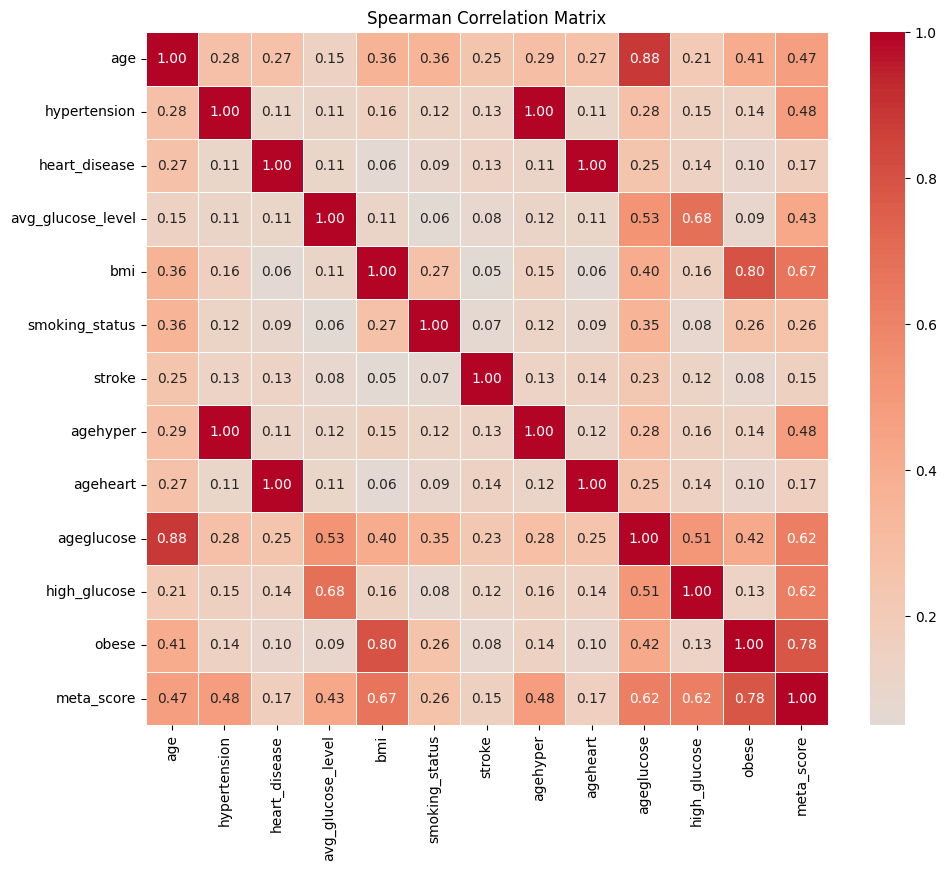

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = [
    "age","hypertension","heart_disease","avg_glucose_level","bmi",
    "smoking_status","stroke",
    "agehyper","ageheart","ageglucose",
    "high_glucose","obese","meta_score"
]

corr = df_co1[num_cols].corr(method="spearman")

plt.figure(figsize=(11,9))
sns.heatmap(
    corr,
    annot=True,          # 수치 표시
    fmt=".2f",           # 소수점 2자리
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Spearman Correlation Matrix")
plt.show()


다중 공산성이 너무 심해서 안 될듯... 그나마 meta_score 정도 쓸 수 있긴 한데 이것도 애매해서 보류 ..